# 回帰の例題

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.datasets import boston_housing

np.random.seed(20201231)
tf.random.set_seed(20201231)

print("tensorflow version : " + tf.__version__)

tensorflow version : 2.3.1


# Load dataset

In [2]:
(x_train, y_train), (x_test, y_test) =  boston_housing.load_data()
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

print('\nx_train')
print('\n犯罪発生率、平均部屋数等')
print(x_train)
print('\ny_train')
print('\n住宅価格の中央値(1,000ドル単位)')
print(y_train)

x_train.shape:  (404, 13)
y_train.shape:  (404,)
x_test.shape:  (102, 13)
y_test.shape:  (102,)

x_train

犯罪発生率、平均部屋数等
[[1.23247e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 ... 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.75520e+02
  3.26000e+00]
 ...
 [3.46600e-02 3.50000e+01 6.06000e+00 ... 1.69000e+01 3.62250e+02
  7.83000e+00]
 [2.14918e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.61950e+02
  1.57900e+01]
 [1.43900e-02 6.00000e+01 2.93000e+00 ... 1.56000e+01 3.76700e+02
  4.38000e+00]]

y_train

住宅価格の中央値(1,000ドル単位)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3

# Modify the input data

In [3]:
print('入力データの範囲がバラバラのため、正規化を行う')
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

print(x_train)

入力データの範囲がバラバラのため、正規化を行う
[[-0.27224633 -0.48361547 -0.43576161 ...  1.14850044  0.44807713
   0.8252202 ]
 [-0.40342651  2.99178419 -1.33391162 ... -1.71818909  0.43190599
  -1.32920239]
 [ 0.1249402  -0.48361547  1.0283258  ...  0.78447637  0.22061726
  -1.30850006]
 ...
 [-0.40202987  0.99079651 -0.7415148  ... -0.71712291  0.07943894
  -0.67776904]
 [-0.17292018 -0.48361547  1.24588095 ... -1.71818909 -0.98764362
   0.42083466]
 [-0.40422614  2.04394792 -1.20161456 ... -1.30866202  0.23317118
  -1.15392266]]


# Create deep learning layer

In [4]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_absolute_error'])
    return model

# Trainning

In [5]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_x_train = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_y_train = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(val_x_train, val_y_train),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


# Validation

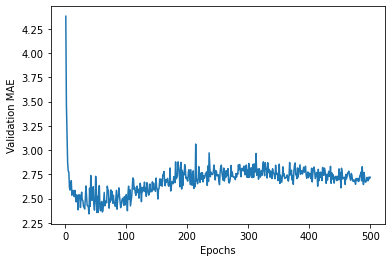

In [6]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

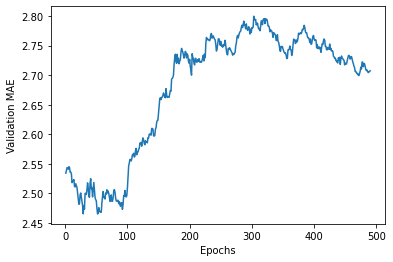

In [7]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Evaluate

In [8]:
model = build_model()
model.fit(x_train, y_train,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 998us/step - loss: 19.2892 - mean_absolute_error: 2.8949
